In [1]:
cd ~/Workspace/gm2/studies/field-shimming/ring-geometry

/Users/matthias/Workspace/gm2/studies/field-shimming/ring-geometry


In [2]:
%matplotlib inline

from IPython.display import display, Markdown
import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d, griddata
import matplotlib as mpl
import matplotlib.pyplot as plt
import ROOT as r
import seaborn as sns

# Set the figure size to span the notebook.
mpl.rcParams['figure.figsize'] = (18, 6)
mpl.style.use('fivethirtyeight')
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.facecolor'] = '#ffffff'
mpl.rcParams['figure.facecolor'] = '#ffffff'
mpl.rcParams['image.cmap'] = 'viridis'

colors = sns.hls_palette(10, l=0.3, s=0.8)

def finish_plot(ylabel=r'z [$\mu$ m]'):
    plt.xlabel(r'$\theta$ [deg]')
    plt.xlim(0, 360)
    plt.ylabel(ylabel)
    
    yoke_label = ord('A')
    
    for i in xrange(0, 37):

        x = (i * 10.0 - 15.0 - 0.1012) % 360.0

        if i % 3 == 0:
            plt.axvline(x, linestyle='-', color='k', alpha=0.2)

        else:
            plt.axvline(x, linestyle='--', color='k', alpha=0.2)
        
        if i is not 0:
            if i < 10:
                s = str(i) + ' '
            else:
                s = str(i)
                
            plt.figtext(0.052 + i * (0.868 / 36.0), 0.86, s, color='k', alpha=0.4)
            
        if (i % 3) == 1:
            plt.figtext(0.052 + i * (0.868 / 36.0), 0.82, chr(yoke_label), color='k', alpha=0.4)
            yoke_label += 1
            
    plt.show()

    
def sinusoid(phi, amp, baseline, phase):
    return amp * np.cos((phi - phase) * np.pi / 180.0) + baseline


def pole3(x, c1, c2, a0, a1, a2, a3):
    v = (a0 + c1 - a1 * 5.0 + a2 * 5.0**2 - a3 * 5.0**3) * (x < -5.0)
    v += (a0 + c2 + a1 * 5.0 + a2 * 5.0**2 + a3 * 5.0**3) * (x > 5.0)
    v += (a0 + a1 * x + a2 * x**2 + a3 * x**3) * (x >= -5.0) * (x <= 5.0)
    return v


def pole5(x, c1, c2, a0, a1, a2, a3, a4, a5):
    v = (a0 + c1 - a1 * 5.0 + a2 * 5.0**2 - a3 * 5.0**3 + a4 * 5.0**4 - a5 * 5.0**5) * (x < -5.0)
    v += (a0 + c2 + a1 * 5.0 + a2 * 5.0**2 + a3 * 5.0**3 + a4 * 5.0**4 + a5 * 5.0**5) * (x > 5.0)
    v += (a0 + a1 * x + a2 * x**2 + a3 * x**3 + a4 * x**4 + a5 * x**5) * (x >= -5.0) * (x <= 5.0)
    return v


Welcome to ROOTaaS 6.06/02


# Global Top Pole Adjustment Plan

The aim of this notebook is to calculate a plan to geometrically align the top poles to a certain height (and azimuthal tilt by design), and radial tilt with respect to the plane of the storage ring.  First, the laser data and several tilt measurements are used to construct a model of the bottom poles, then the capacitec data can be used to construct a model of the top poles.

## Set Parameters

In [3]:
# Input Configuration
datafile = 'data-in/full_scan_032.root'
pole_step_tilt_data = 'data-in/tilt_pole_boundaries_03_26_2016.csv'
radial_tilt_data = 'data-in/pole_tilts_03_29_2016.csv'
radial_tilt_cal = 'data-in/rad_tilt_cal_03_29_2016.csv'

radial_tilt_cal_field_on = 'data-in/rad_tilt_cal_03_27_2016.csv'
radial_tilt_data_field_on = 'data-in/pole_tilts_03_27_2016.csv'
radial_tilt_cal_field_off = 'data-in/rad_tilt_cal_03_29_2016.csv'
radial_tilt_data_field_off = 'data-in/pole_tilts_03_29_2016.csv'

inside_micrometer_data = 'data-in/inside_micrometer_03_28_2016.csv'

# Set the target parametersf or the top and bottom poles.
bot_z0 = 0.0
bot_rad0 = 45.0

top_z0 = 425.0
top_rad0 = -50.0

# Set these to to one (true) to indicate poles that are fixed.
freeze_bot_pole = np.zeros(36)
freeze_top_pole = np.zeros(36)
#freeze_pole[23:35] = 1
#freeze_pole[8:17] = 1

laser_z_min = -20000
laser_z_max = +20000

# Polynomial fit bounds: [
#     elevation shift to previous pole,
#     elevation shift to next pole,
#     baseline elevation of current pole,
#     maximum strength of linear term,
#     maximum strength of quadratic term,
#     maximum strength of cubic term,
#     maximum strength of quartic term,
#     maximum strength of quintic term]
bot_lb = np.array([200.0, 200.0, 250.0, 50.0, 4.0, 0.4, 0.16, 0.032]) * -1
bot_ub = np.array([200.0, 200.0, 250.0, 50.0, 0.0, 0.4, 0.00, 0.032])

top_lb = np.array([200, 200, 1000.0, 50, 4, 0.4, 0.16, 0.032]) * -1
top_ub = np.array([200, 200, 1000.0, 50, 4, 0.4, 0.16, 0.032])

bot_pole_fit_range_phi = 6.0 # Degrees (one degree on neighbor poles)
top_pole_fit_range_phi = 4.8
pole_fit_neighbor_w = 100.0 # Make sure we get the boundaries right.

# Constants
laser_to_cart_offset = 0.368
laser_to_pnmr_offset = -1.42
laser_to_ctec_offset = -0.735

cart_width_m = 0.32385
 
# -25.197 calibration for all summed, +30.63 if no lowers as of 16/04/01
ctec_outer_inner_offset = 30.63
ctec_lower_factor = 0.0
ctec_width_m = 0.219075

# Converts azimuthal and radial tilt bits to microns.
tilt_sensor_length_m = 11.75 * 0.0254
tilt_sensor_width_m = 2.25 * 0.0254
tilt_bits_to_urads = 1.29
azi_tilt_bits_to_microns = tilt_bits_to_urads * tilt_sensor_width_m
rad_tilt_bits_to_microns = tilt_bits_to_urads * tilt_sensor_length_m

# Pole dimensions
pole_length_inner = 1.2200
pole_length_center = 1.2413
pole_length_outer = 1.2608
pole_width_m = 0.53

pole_feet_phi_from_center = 4.878
pole_feet_phi_spacing = pole_feet_phi_from_center / 2.0

ppm_dipole_per_um = -5.5 # from geometry, -3.488331 from bottom moves
ppm_n_quad_per_urad = -0.25 # from geometry, -0.157714 from bottom moves


## Load Data

In [4]:
# Load and pre-process all the data.
f = r.TFile(datafile)
t = f.Get('t')

# Allocated data arrays.
cart_z = np.empty(t.GetEntries())
cart_phi = np.empty(t.GetEntries())

b_phi = np.empty(t.GetEntries())
b_dipole = np.empty(t.GetEntries())
b_n_quad = np.empty(t.GetEntries())

ctec_phi = np.empty(t.GetEntries())
ctec_inner_lo = np.empty(t.GetEntries())
ctec_inner_up = np.empty(t.GetEntries())
ctec_outer_lo = np.empty(t.GetEntries())
ctec_outer_up = np.empty(t.GetEntries())

# Loop over the ROOT TTree.
for i in xrange(t.GetEntries()):
    t.GetEntry(i)
    
    cart_phi[i] = (t.phi_2 + laser_to_cart_offset) % 360
    cart_z[i] = t.z_2 * 1e6 # Convert meters to microns    

    b_phi[i] = (t.phi_2 + laser_to_pnmr_offset) % 360
    b_dipole[i] = t.multipole[0]
    b_n_quad[i] = t.multipole[1]
    
    ctec_phi[i] = (t.phi_2 + laser_to_ctec_offset) % 360
    ctec_inner_lo[i] = t.inner_lo * ctec_lower_factor
    ctec_inner_up[i] = t.inner_up
    ctec_outer_lo[i] = t.outer_lo * ctec_lower_factor
    ctec_outer_up[i] = t.outer_up + ctec_outer_inner_offset
    
# Clean up the laser data.
indices = np.where(cart_z > 0.5)
cart_phi = cart_phi[indices]
cart_z = cart_z[indices]

# Subtract the height offset to put things in the same space as our reconstruction.
cart_z -= cart_z.mean()

indices = np.where(cart_z > laser_z_min)
cart_z = cart_z[indices]
cart_phi = cart_phi[indices]
indices = np.where(cart_z < laser_z_max)
cart_z = cart_z[indices]
cart_phi = cart_phi[indices]

cart_z -= cart_z.min() + 110

# Construct weights based on azimuthal spacing
phi_w = np.empty(cart_phi.shape)
t_phi = (cart_phi - laser_to_cart_offset) % 360
phi_w[1:-1] = 0.5 * (t_phi[2:] - t_phi[:-2])
phi_w[0] = 0.5 * (t_phi[1] + 360.0 - t_phi[-1])
phi_w[-1] = 0.5 * (t_phi[0] + 360.0 - t_phi[-2])
phi_w = np.abs(phi_w)

# Open the tilt data for pole steps and radial tilts.
d_pb = np.genfromtxt(pole_step_tilt_data, skip_header=True)
d_tilt_cal = np.genfromtxt(radial_tilt_cal, skip_header=True)
d_tilt = np.genfromtxt(radial_tilt_data, skip_header=True)

# Take the average of the two steps.
dz = (2 * d_pb[:, 4] - d_pb[:, 2] - d_pb[:, 6]) * 0.5 * azi_tilt_bits_to_microns
drad = (d_pb[:, 5] - d_pb[:, 3]) * rad_tilt_bits_to_microns

dz += 0.5 * drad
dz_outer = dz - 0.5 * drad

# Convert the azimuthal tilts and copy them to an average tilt per pole used in the simplest model.
d_tilt_azi = (d_tilt[:, 2] - d_tilt_cal[:, 2].mean()) * tilt_bits_to_urads
dzds = np.array(d_tilt_azi)

# Refill the z values and shift into [0, 360]
z = np.empty(dz.shape[0] * 100)
phi = np.linspace(0, 360, z.shape[0])

for i in xrange(z.shape[0]):
    idx = (i - 50) % z.shape[0] # To set between [0, 360] instead of [-5, 355]
    z[idx] = dz[:i/100].sum()
    z[idx] += dzds[i/100] * (i % 100) * pole_length_inner / 100.0
    z[idx] += dzds[:i/100].sum() * pole_length_inner
    
# Divide the different by the number of weight of pieces in between z_i and z_f
dzds0 = (z[-51] - z[-50] - dz[-1]) / (pole_length_inner * 35.99)

# Add the offset to the slopes
dzds -= dzds0

# Refill the z values and shift into [0, 360]
z = np.empty(dz.shape[0] * 100)
phi = np.linspace(0, 360, z.shape[0])

for i in xrange(z.shape[0]):
    # To set between [0, 360] instead of [-5, 355]
    idx = (i - 50) % z.shape[0]
    z[idx] = dz[:i/100].sum()
    z[idx] += dzds[i/100] * (i % 100) * pole_length_inner / 100.0
    z[idx] += dzds[:i/100].sum() * pole_length_inner

# Load the data for radial tilts field on/off.
d1_tilt_rad_cal = np.genfromtxt(radial_tilt_cal_field_on, skip_header=True)
d1_tilt = np.genfromtxt(radial_tilt_data_field_on, skip_header=True)
d1_tilt_rad = (d1_tilt[:, 2] - d1_tilt_rad_cal[:, 2].mean()) * tilt_bits_to_urads

d2_tilt_rad_cal = np.genfromtxt(radial_tilt_cal_field_off, skip_header=True)
d2_tilt = np.genfromtxt(radial_tilt_data_field_off, skip_header=True)
d2_tilt_rad = (d2_tilt[:, 2] - d2_tilt_rad_cal[:, 2].mean()) * tilt_bits_to_urads

# A convenient variable for plotting pole adjustments.
pole_feet_phi = np.empty(36 * 5)

for i in xrange(36):
    for j in xrange(5):
        pole_feet_phi[i * 5 + j] = -pole_feet_phi_from_center + pole_feet_phi_spacing * j + 10 * i

# Load inside micrometer measurements.
d_inside_mic = np.genfromtxt(inside_micrometer_data, skip_header=True, delimiter=',')[:180]
im_z_inner = d_inside_mic[:, 4]
im_z_outer = d_inside_mic[:, 7]

idx = np.where(im_z_outer != np.nan)
im_phi = pole_feet_phi[idx]
im_z_inner = im_z_inner[idx]
im_z_outer = im_z_outer[idx]

idx = np.where(im_z_inner != np.nan)
im_phi = pole_feet_phi[idx]
im_z_inner = im_z_inner[idx]
im_z_outer = im_z_outer[idx]


## Plot some of the Data

### Laser Height vs Azimuth

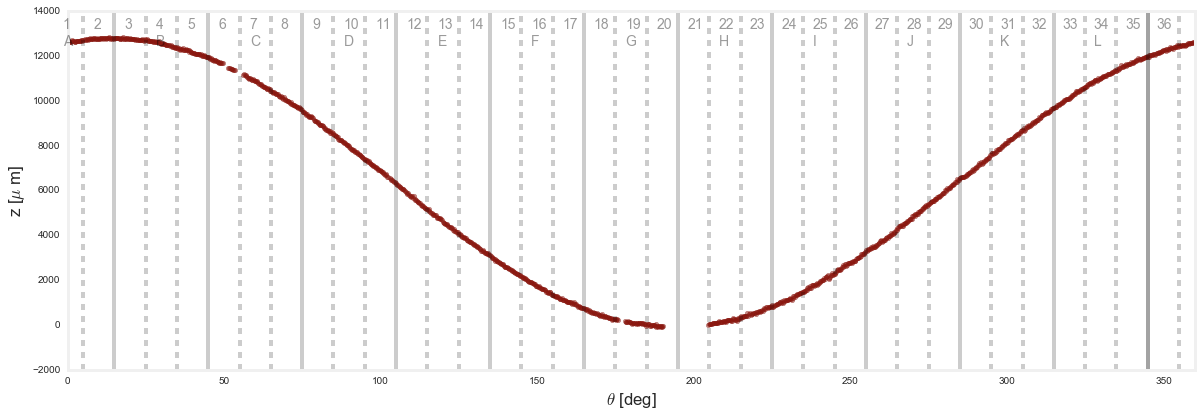

### Tilt Model (With Closure)

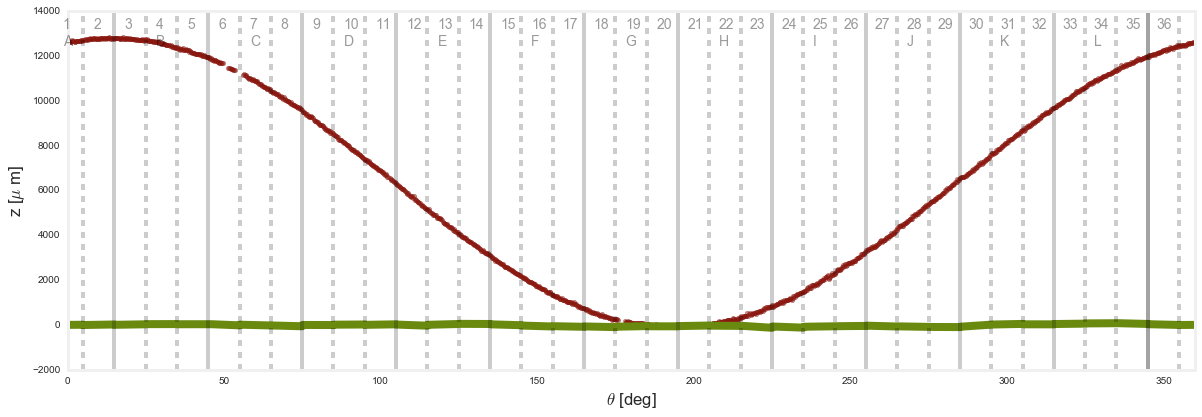

In [5]:
# Now plot some of the data for visual validation.
display(Markdown('### Laser Height vs Azimuth'))
plt.scatter(cart_phi, cart_z, color=colors[0], alpha=0.5)
finish_plot()

display(Markdown('### Tilt Model (With Closure)'))
plt.scatter(cart_phi, cart_z, color=colors[0], alpha=0.5)
plt.plot(phi, z, c=colors[2], linewidth=8.0)
finish_plot()


## Dealing with the ring tilt plane and laser tilt plane

One can observe from differencing the simple tilt model and laser data, that there are residual tilt planes still involved in this story.  One tilt plane is the ring with respect to gravity which we can get a proxy for by comparing the tilt model with a flat plane.  The second tilt plane is the laser tracker with respect to the ring tilt plane (or gravity, but we are using the ring as our basis).  This one we tease out by looking for one omega between the laser data and the corrected tilt sensor model.

### Ring Tilt Plane

(amp, baseline, phase) => (48.85, -12.83, 28.09)


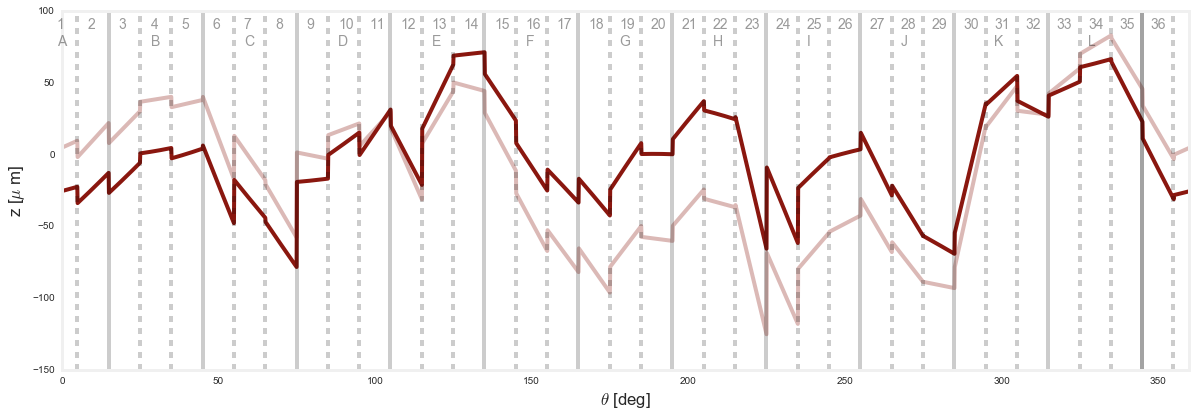

### Laser Height vs Tilt Model (Ring Tilt Plane Removed)

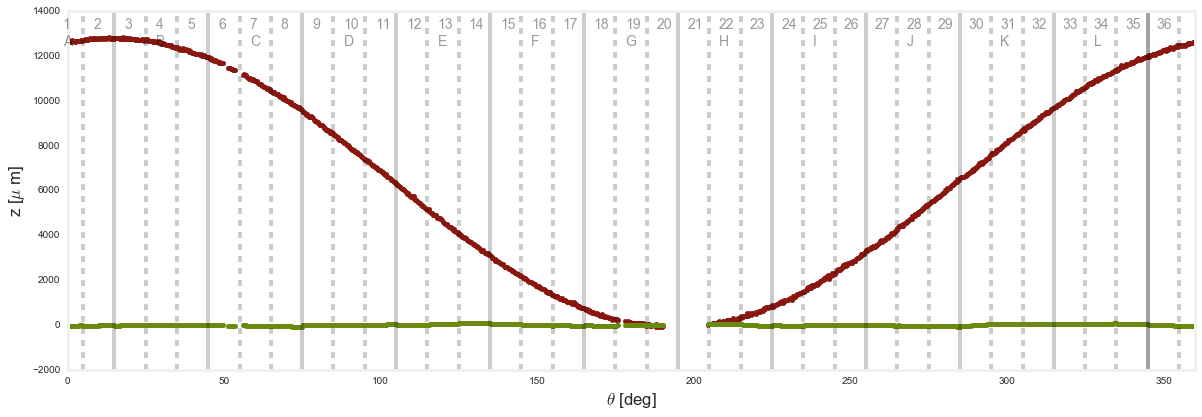

### Laser Tilt Plane (Difference of Laser Height and Tilt Model)

(amp, baseline, phase) => (6446.59, 6378.93, 14.01)


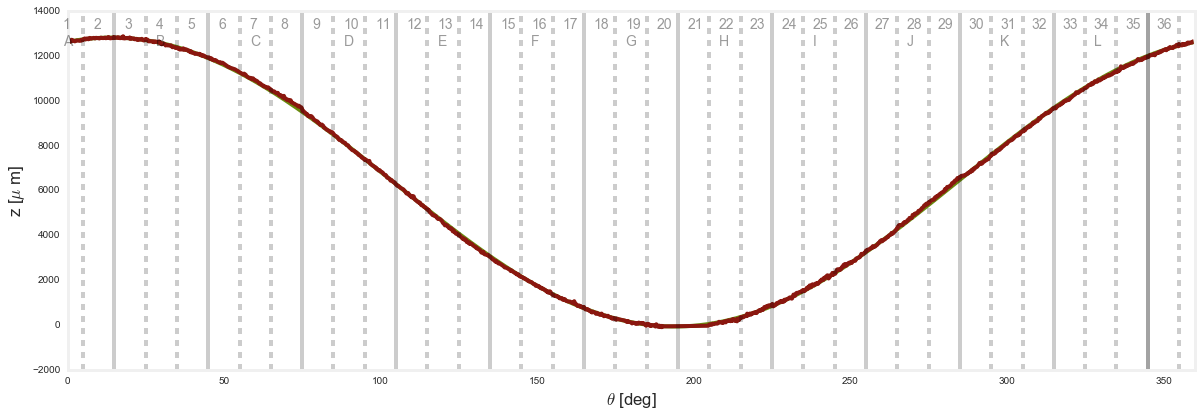

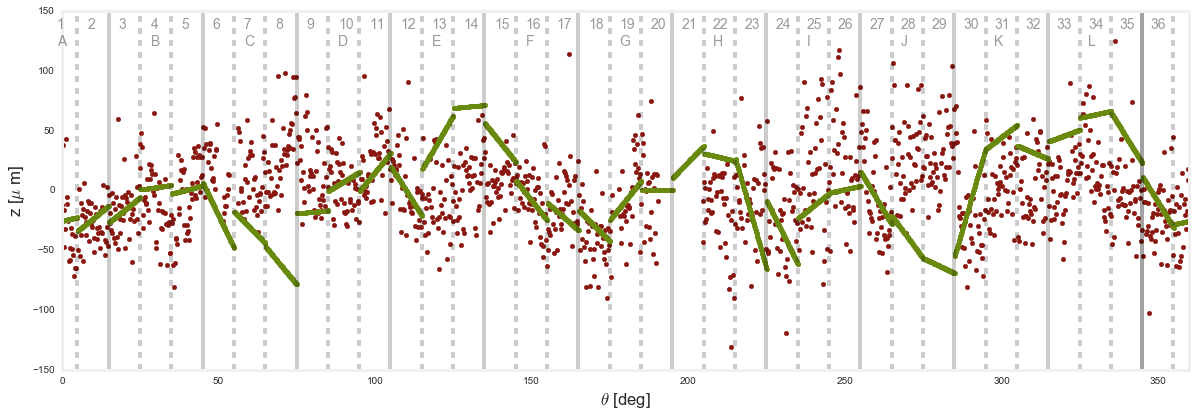

In [6]:
display(Markdown('### Ring Tilt Plane'))

# Copy the arrays to use in fits.
f_z = np.array(z)
f_phi = np.array(phi)

p, cov = curve_fit(sinusoid, f_phi, f_z)
print "(amp, baseline, phase) => (%.2f, %.2f, %.2f)" % (p[0], p[1], p[2] % 360.0)

plt.plot(phi, z, color=colors[0], alpha=0.3)
plt.plot(phi, z - sinusoid(phi, p[0], p[1], p[2]), color=colors[0])
finish_plot()

z_corr = np.array(z - sinusoid(phi, p[0], p[1], p[2]))

display(Markdown('### Laser Height vs Tilt Model (Ring Tilt Plane Removed)'))

f = interp1d(phi, z_corr)

plt.scatter(cart_phi, cart_z, color=colors[0])
plt.scatter(cart_phi, f(cart_phi), color=colors[2])
finish_plot()

display(Markdown('### Laser Tilt Plane (Difference of Laser Height and Tilt Model)'))

# Put the data onto an evenly spaced grid
f_cart_z = interp1d(cart_phi, cart_z - f(cart_phi))
cart_phi_grid = np.linspace(0.5, 359.5, 5001)
cart_z_grid = f_cart_z(cart_phi_grid)

p, cov = curve_fit(sinusoid, cart_phi_grid, cart_z_grid)
print "(amp, baseline, phase) => (%.2f, %.2f, %.2f)" % (p[0], p[1], p[2] % 360.0)

plt.plot(cart_phi_grid, sinusoid(cart_phi_grid, p[0], p[1], p[2]), color=colors[2])
plt.plot(cart_phi_grid, cart_z_grid, color=colors[0])
finish_plot()

plt.scatter(cart_phi, cart_z - sinusoid(cart_phi, p[0], p[1], p[2]), color=colors[0])
plt.scatter(phi, z_corr, color=colors[2])
finish_plot()

cart_z_corr = np.array(cart_z - sinusoid(cart_phi, p[0], p[1], p[2]))


## Fitting for Curvature of Bottom Poles

We need to estimate how to fix the curvature of each pole.  About the best we can do here is use the laser data.

### Laser Data For All Poles

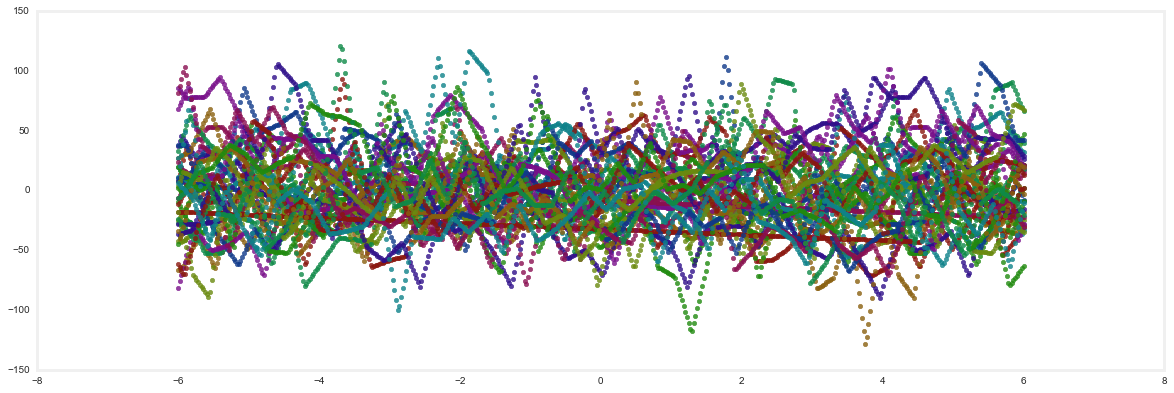

### Quintic Fits to Each Pole Curvature

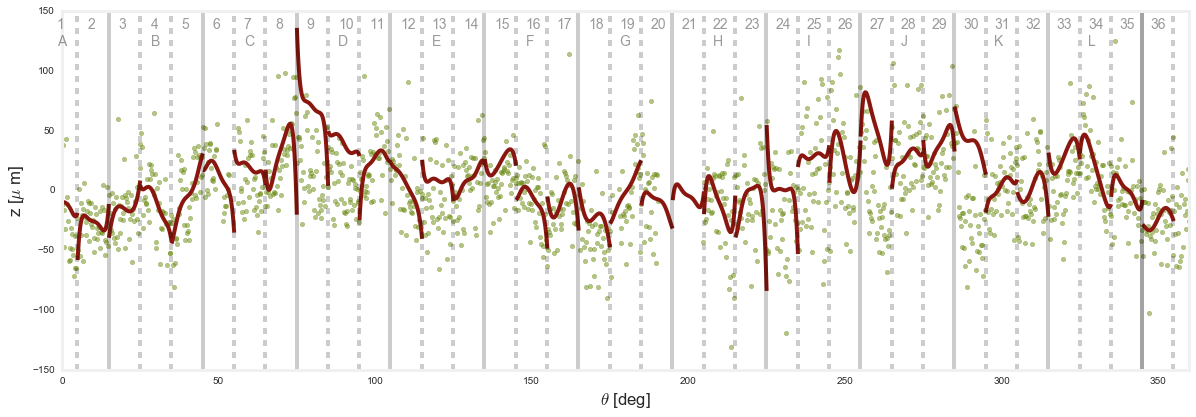

In [7]:
# Try fitting each pole to a parabola
fit_params = np.empty([36, 8])
fit_tilt = np.empty(36)

bounds = (np.array(bot_lb), np.array(bot_ub))

for i in xrange(36):
    f_phi = (cart_phi - i * 10 + 15) % 360
    f_z = np.array(cart_z_corr)
    indices = np.where(f_phi > 0.0)
    f_phi = f_phi[indices]
    f_z = f_z[indices]
    f_w = phi_w[indices]
    indices = np.where(f_phi < 30.0)
    f_phi = f_phi[indices]
    f_z = f_z[indices]
    f_w = f_w[indices]

    indices = f_phi.argsort()
    f_phi = f_phi[indices]
    f_z = f_z[indices]
    
    f_phi -= 15.0
    
    if f_phi.shape[0] == 10:
        fit_params[i, :] = np.array([0, 0, 0, 0, 0, 0, 0, 0])
        continue        
        
    else:
        # Set the neighbor pole offsets based on tilt sensor data.
        bounds[0][0] = -dz[i-1]
        bounds[1][0] = -dz[i-1] + 0.001
        bounds[0][1] = dz[i]
        bounds[1][1] = dz[i] + 0.001
        ff = interp1d(f_phi, f_z)
        
        if f_phi.min() > -bot_pole_fit_range_phi:
            phi_min = f_phi.min()
        
        else:
            phi_min = -bot_pole_fit_range_phi
        
        if f_phi.max() < bot_pole_fit_range_phi:
            phi_max = f_phi.max()
        
        else:
            phi_max = bot_pole_fit_range_phi

        f_phi = np.linspace(phi_min, phi_max, 501)
        f_z = ff(f_phi)
        sigma = np.ones(f_phi.shape[0])
        sigma[np.where(f_phi < -5.0)] /= pole_fit_neighbor_w
        sigma[np.where(f_phi > 5.0)] /= pole_fit_neighbor_w
        p, pcor = curve_fit(pole5, f_phi, f_z, bounds=bounds, sigma=sigma, max_nfev=10000)
        plt.scatter(f_phi, f_z, color=colors[i%10], alpha=0.8)
        fit_params[i, :] = p

display(Markdown('### Laser Data For All Poles'))     
plt.show()
    
for i in xrange(36):
    f_phi = np.linspace(10.0 * i - 4.99, 10.0 * i + 4.99, 100)
    p_phi = np.linspace(-4.99, 4.99, 100)
    par = fit_params[i, :]
    plt.plot(f_phi, pole5(p_phi, par[0], par[1], par[2], par[3], par[4], par[5], par[6], par[7]), color=colors[0])
    
    fit_tilt[i] = pole5(pole_length_center, par[0], par[1], par[2], par[3], par[4], par[5], par[6], par[7])
    fit_tilt[i] -= pole5(-pole_length_center, par[0], par[1], par[2], par[3], par[4], par[5], par[6], par[7])
    fit_tilt[i] /= tilt_sensor_length_m

display(Markdown('### Quintic Fits to Each Pole Curvature'))
plt.scatter(cart_phi, cart_z_corr, color=colors[2], alpha=0.5)
finish_plot()



## Radial Pole Tilts

The last piece of the puzzle here is inflecting the correct radial pole tilt on the bottom pole pieces.  We have data from field off measurements, and we began the process of taking field on measurements today, 3/15/2016.  Comparing the two and knowing that we want to shoot for 45 $\mu rad$ of radial closure with the field on, we can make a plan for the radial adjustment in our bottom pole movement program.

### Measured Radial Tilts with Field On/Off

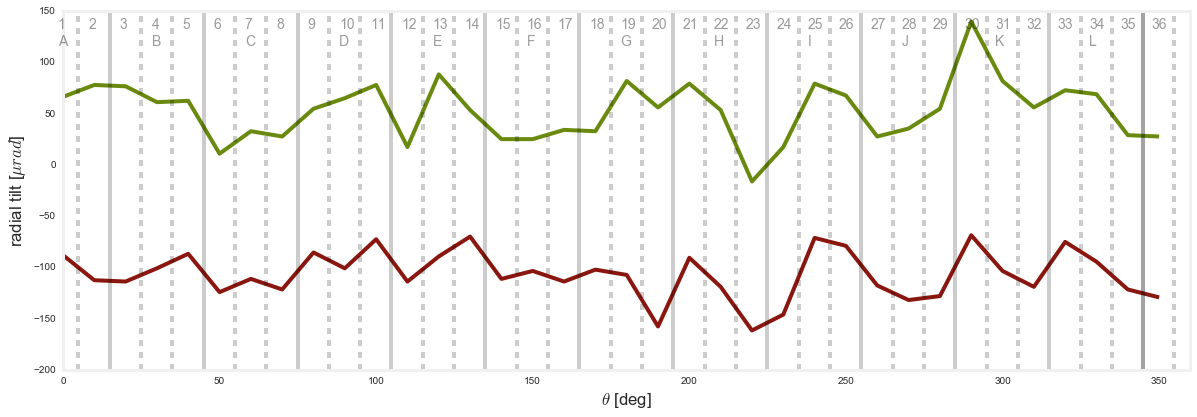

### Radial Tilt Differences with Field On/Off

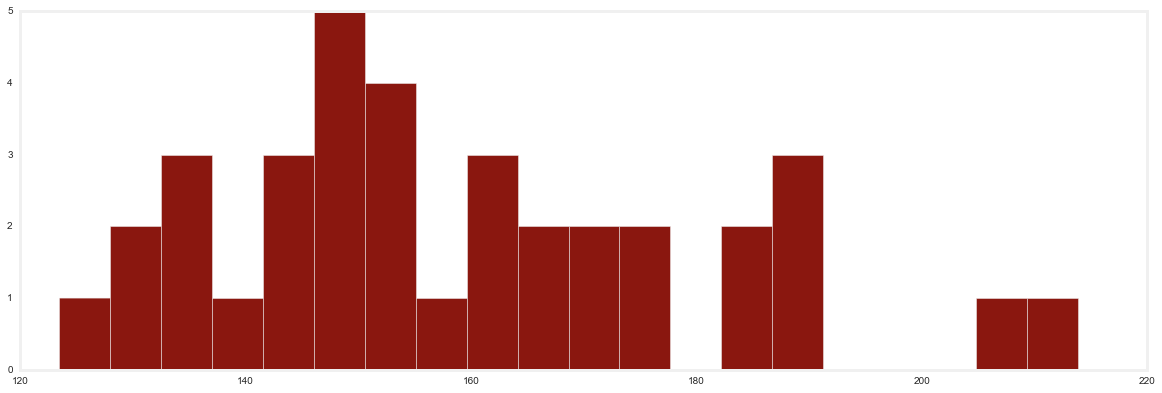

In [8]:
plt.plot(np.linspace(0, 350, 36), d1_tilt_rad, color=colors[0])
plt.plot(np.linspace(0, 350, 36), d2_tilt_rad, color=colors[2])
display(Markdown('### Measured Radial Tilts with Field On/Off'))
finish_plot('radial tilt [$\mu rad$]')

display(Markdown('### Radial Tilt Differences with Field On/Off'))
plt.hist(d2_tilt_rad - d1_tilt_rad, bins=20, color=colors[0])
plt.show()


## Bottom Pole Model

We can use the steps from tilt sensor measurements, the curvature from most of the polynomial fits, and the radial tilts from measurements field on/off.  With all of this info together, we can create a model of the bottom poles.  The model can be used to determine a correction adjustments, but it can also serve as a reference to build a model of the top poles.

### Bottom Pole Model

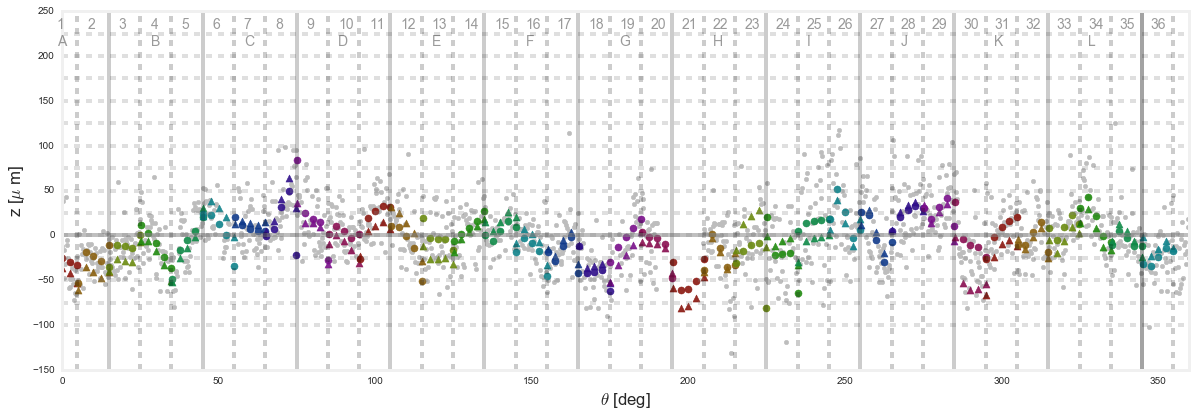

In [9]:
# Calculate pole foot adjustments

# Convenience variables
bottom_feet = np.zeros([36, 10])
mean_pole_z = np.zeros(36)

for i in xrange(36):

    # Calculate the height displacement
    idx = np.where((cart_phi - (10.0 * i - 5.0)) % 360 < 10.0)
    t_z = cart_z_corr[idx]
    t_phi = cart_phi[idx]

    t_dz = bot_z0 - t_z.mean()
    bottom_feet[i, :] = t_dz
    
    if i not in [19, 20]:
        par = fit_params[i, :]
        for j in xrange(5):
            a = -pole_feet_phi_from_center + pole_feet_phi_spacing * j
            bottom_feet[i, j] -= pole5(a, par[0], par[1], 0.0, par[3], par[4], par[5], par[6], par[7])
            bottom_feet[i, j + 5] -= pole5(a, par[0], par[1], 0.0, par[3], par[4], par[5], par[6], par[7])
            
    else:
        for j in xrange(5):
            f = interp1d(phi, z)
            t_dz0 = (f(t_phi) - t_z).mean()
            a = 10.0 * i - pole_feet_phi_from_center + pole_feet_phi_spacing * j
            bottom_feet[i, j] -= f(a) - t_dz0
            bottom_feet[i, j + 5] -= f(a) - t_dz0
        
    
    # Take care of the radial tilt as an average
    for j in xrange(5):
        bottom_feet[i, j + 5] += (d2_tilt_rad[i] - bot_rad0) * pole_width_m

        # Compensate for changing both the inner and outer heights
        inner_z_shift = (d2_tilt_rad[i] - bot_rad0) * (pole_width_m - cart_width_m) * 0.5
        bottom_feet[i, j + 0] -= inner_z_shift
        bottom_feet[i, j + 5] -= inner_z_shift

# Copy bottom_feet so that it doesn't change while we are correcting it.
t_bottom_feet = np.array(bottom_feet)

# Now take care bad pole steps
for i in xrange(36):
    
    c = pole_width_m / tilt_sensor_length_m
    w = 0.5
    
    t_dz_inner = -t_bottom_feet[i, 0] + t_bottom_feet[i - 1, 4]
    t_dz_outer = -t_bottom_feet[i, 5] + t_bottom_feet[i - 1, 9]
    
    a3_inner = w * (t_dz_inner - c * dz[i-1]) / pole_feet_phi_from_center**3
    a3_outer = w * (t_dz_outer - c * dz_outer[i-1]) / pole_feet_phi_from_center**3
    
    for j in xrange(0, 2):
        a = -pole_feet_phi_from_center + pole_feet_phi_spacing * j
        bottom_feet[i, j] += a3_inner * np.abs(a**3)
        bottom_feet[i, j + 5] += a3_outer * np.abs(a**3)
    
    w = 0.5
    t_dz_inner = -t_bottom_feet[(i + 1) % 36, 0] + t_bottom_feet[i, 4]
    t_dz_outer = -t_bottom_feet[(i + 1) % 36, 5] + t_bottom_feet[i, 9]
    
    a3_inner = w * (t_dz_inner - c * dz[i]) / pole_feet_phi_from_center**3
    a3_outer = w * (t_dz_outer - c * dz_outer[i]) / pole_feet_phi_from_center**3
    
    for j in xrange(3, 5):
        a = -pole_feet_phi_from_center + pole_feet_phi_spacing * j
        bottom_feet[i, j] -= a3_inner * np.abs(a**3)
        bottom_feet[i, j + 5] -= a3_outer * np.abs(a**3)
        
display(Markdown('### Bottom Pole Model'))
plt.scatter(cart_phi, cart_z_corr, color='#bdbdbd', alpha=1.0)

for i in xrange(36):
    t_phi = np.linspace(10.0 * i - pole_feet_phi_from_center, 10.0 * i + pole_feet_phi_from_center, 5)
    plt.scatter(t_phi, bot_z0 - bottom_feet[i, :5], alpha=0.9, s=50.0, color=colors[i%10])
    plt.scatter(t_phi, bot_z0 - bottom_feet[i, 5:], alpha=0.9, s=50.0, marker='^', color=colors[i%10])

for i in xrange(-4, 10):
    plt.axhline(bot_z0 + i * 25, color='gray', linestyle='--', alpha=0.25)

plt.axhline(bot_z0 + 0.0, color='gray', alpha=0.5)
finish_plot()

header = ['IA', 'IB', 'IC', 'ID', 'IE', 'OA', 'OB', 'OC', 'OD', 'OE']
np.savetxt('data-out/bottom_pole_feet_model.csv', bottom_feet, header=' '.join(header))

pole_feet_phi = np.empty(36 * 5)
for i in xrange(36):
    for j in xrange(5):
        pole_feet_phi[i * 5 + j] = -pole_feet_phi_from_center + pole_feet_phi_spacing * j + 10 * i

bot_feet_inner = bottom_feet[:, :5].flatten()
bot_feet_outer = bottom_feet[:, 5:].flatten()

bot_inner = griddata(pole_feet_phi, bot_feet_inner, ctec_phi)
bot_outer = griddata(pole_feet_phi, bot_feet_outer, ctec_phi)

## Modeling the Top Poles

We can use the bottom pole model as a reference to create a model for the top poles.  In this way the capacitec measurements become absolute measurements with respect to the storage ring plane rather than relative measurements with respect to the bottom poles.

### Raw Capacitec

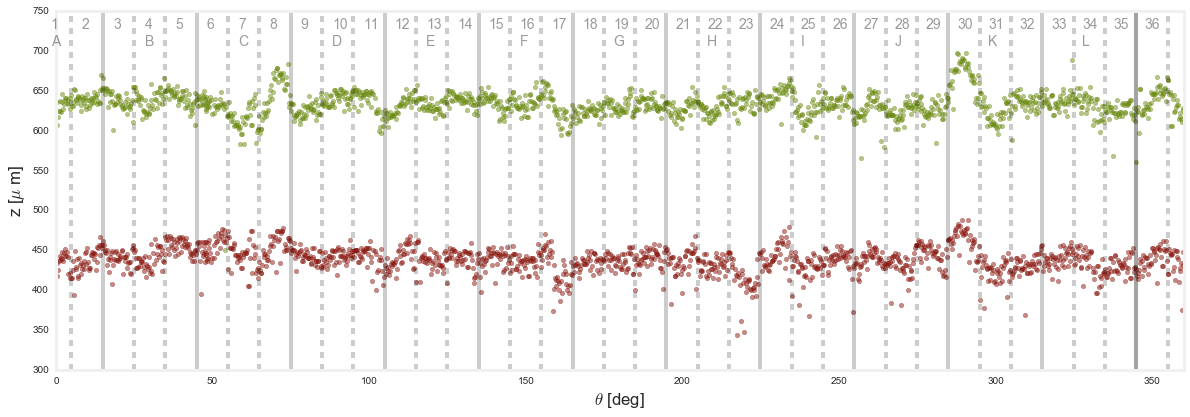

### Top Pole Reconstruction

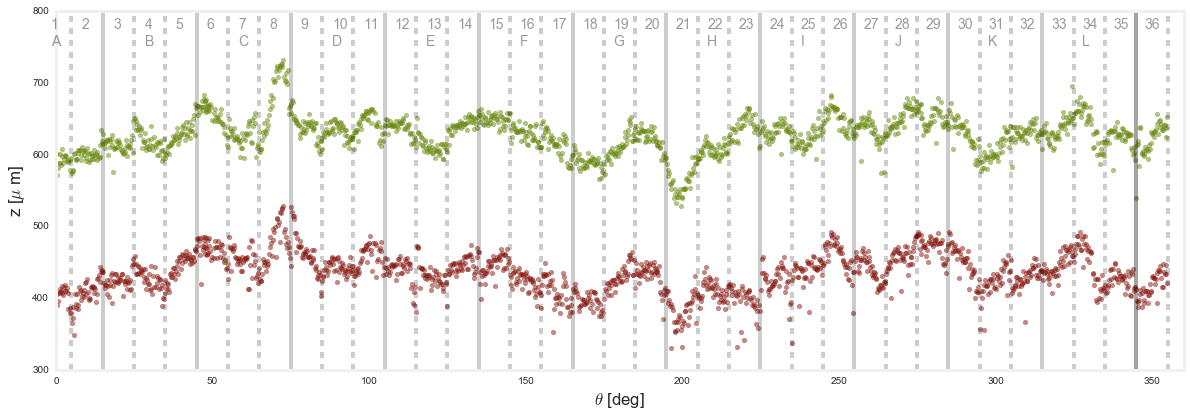

In [10]:
display(Markdown('### Raw Capacitec'))
plt.scatter(ctec_phi, ctec_inner_lo + ctec_inner_up, color=colors[0], alpha=0.5)
plt.scatter(ctec_phi, ctec_outer_lo + ctec_outer_up, color=colors[2], alpha=0.5)
finish_plot()

display(Markdown('### Top Pole Reconstruction'))
top_inner = ctec_inner_up + ctec_inner_lo - (0.8 * bot_inner + 0.2 * bot_outer)
top_outer = ctec_outer_up + ctec_outer_lo - (0.2 * bot_inner + 0.8 * bot_outer)
plt.scatter(ctec_phi, top_inner, color=colors[0], alpha=0.5)
plt.scatter(ctec_phi, top_outer, color=colors[2], alpha=0.5)
finish_plot()

## Polynomial Top Pole Model

### Quintic Fits to Each Pole Curvature

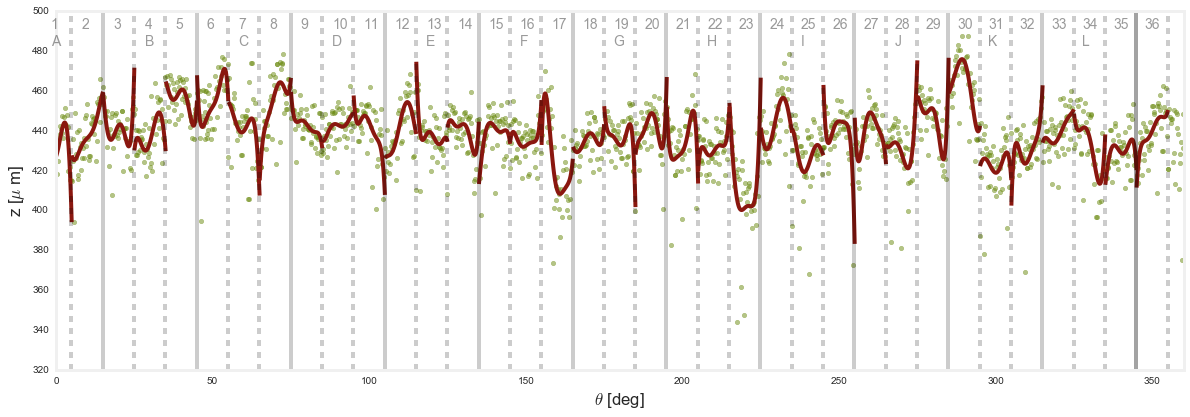

### Quintic Fits to Each Pole Curvature

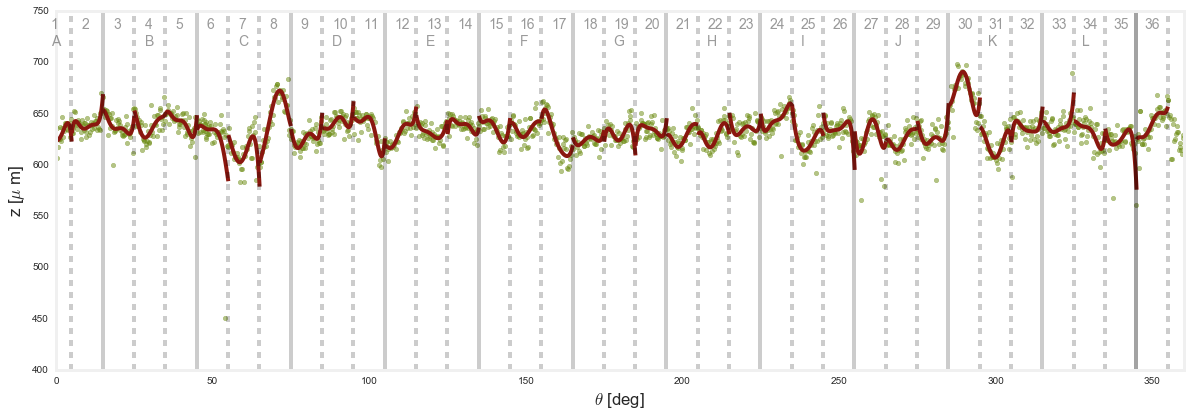

In [11]:
# Try fitting each pole to a parabola
fit_params_inner = np.empty([36, 8])
fit_params_outer = np.empty([36, 8])
fit_tilt = np.empty(36)

bounds = (top_lb, top_ub)

for i in xrange(36):
    f_phi = (ctec_phi - i * 10 + 15) % 360
    f_z = np.array(ctec_inner_up + ctec_inner_lo)
    indices = np.where(f_phi > 0.0)
    f_phi = f_phi[indices]
    f_z = f_z[indices]
    indices = np.where(f_phi < 30.0)
    f_phi = f_phi[indices]
    f_z = f_z[indices]

    indices = f_phi.argsort()
    f_phi = f_phi[indices]
    f_z = f_z[indices]
    
    f_phi -= 15.0
    
    if f_phi.shape[0] == 0:
        continue
        fit_params_inner[i, :] = np.array([0, 0, 0, 0, 0, 0, 0, 0])
        
    else:
        ff = interp1d(f_phi, f_z)
        f_phi = np.linspace(-top_pole_fit_range_phi, top_pole_fit_range_phi, 501)
        f_z = ff(f_phi)
        sigma = np.ones(f_phi.shape[0])
        sigma[np.where(f_phi < -5.0)] *= 0.01
        sigma[np.where(f_phi > 5.0)] *= 0.01
        p, pcor = curve_fit(pole5, f_phi, f_z, bounds=bounds, sigma=sigma, max_nfev=10000)
        fit_params_inner[i, :] = p
        
for i in xrange(36):
    f_phi = (ctec_phi - i * 10 + 15) % 360
    f_z = np.array(ctec_outer_up + ctec_outer_lo)
    indices = np.where(f_phi > 0.0)
    f_phi = f_phi[indices]
    f_z = f_z[indices]
    indices = np.where(f_phi < 30.0)
    f_phi = f_phi[indices]
    f_z = f_z[indices]

    indices = f_phi.argsort()
    f_phi = f_phi[indices]
    f_z = f_z[indices]
    
    f_phi -= 15.0
    
    if f_phi.shape[0] == 0:
        continue
        fit_params_outer[i, :] = np.array([0, 0, 0, 0, 0, 0, 0, 0])
        
    else:
        ff = interp1d(f_phi, f_z)
        f_phi = np.linspace(-top_pole_fit_range_phi, top_pole_fit_range_phi, 501)
        f_z = ff(f_phi)
        sigma = np.ones(f_phi.shape[0])
        sigma[np.where(f_phi < -5.0)] /= pole_fit_neighbor_w
        sigma[np.where(f_phi > 5.0)] /= pole_fit_neighbor_w
        p, pcor = curve_fit(pole5, f_phi, f_z, bounds=bounds, sigma=sigma, max_nfev=10000)
        fit_params_outer[i, :] = p

# Plot all the inner fits        
for i in xrange(36):
    f_phi = np.linspace(10.0 * i - 4.99, 10.0 * i + 4.99, 100)
    p_phi = np.linspace(-4.99, 4.99, 100)
    par = fit_params_inner[i, :]
    plt.plot(f_phi, pole5(p_phi, par[0], par[1], par[2], par[3], par[4], par[5], par[6], par[7]), color=colors[0])

display(Markdown('### Quintic Fits to Each Pole Curvature'))
plt.scatter(ctec_phi, ctec_inner_up + ctec_inner_lo, color=colors[2], alpha=0.5)
finish_plot()

# Plot all the outer fits        
for i in xrange(36):
    f_phi = np.linspace(10.0 * i - 4.99, 10.0 * i + 4.99, 100)
    p_phi = np.linspace(-4.99, 4.99, 100)
    par = fit_params_outer[i, :]
    plt.plot(f_phi, pole5(p_phi, par[0], par[1], par[2], par[3], par[4], par[5], par[6], par[7]), color=colors[0])

display(Markdown('### Quintic Fits to Each Pole Curvature'))
plt.scatter(ctec_phi, ctec_outer_up + ctec_outer_lo, color=colors[2], alpha=0.5)
finish_plot()

### Top Pole - Inner Height Goal

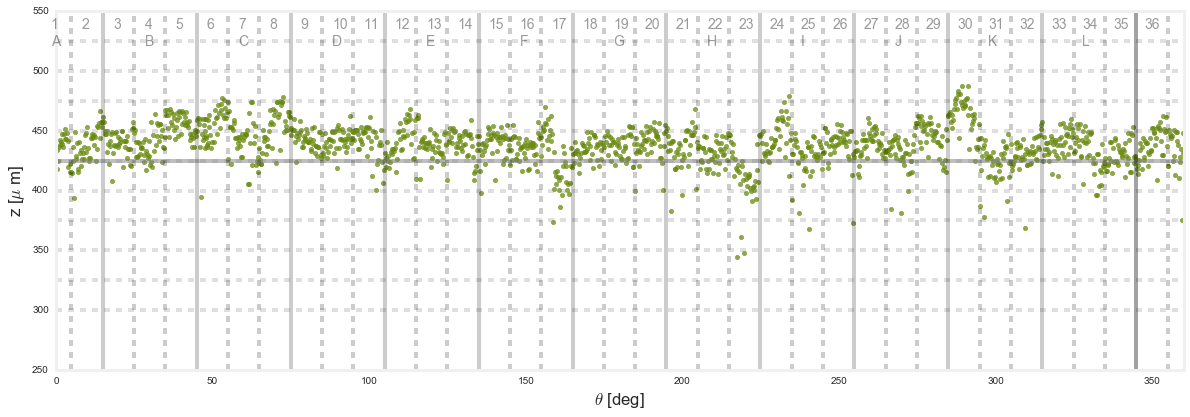

### Top Pole - Outer Height Goal

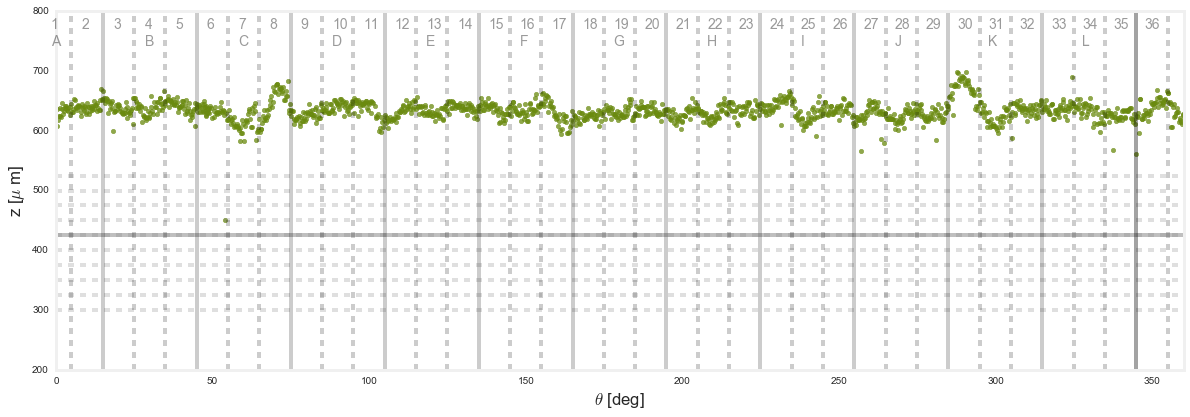

### Top Pole Adjustment Plan

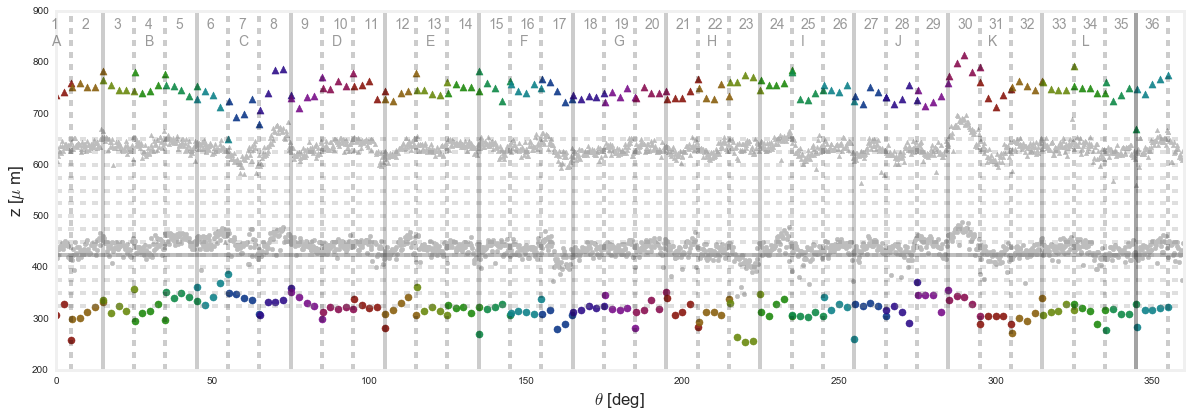

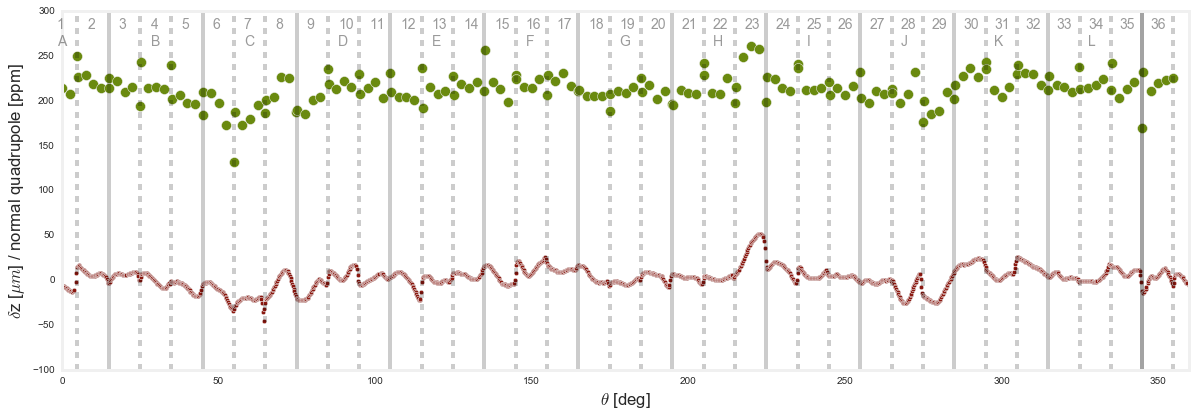

### Inner Feet Shim Changes

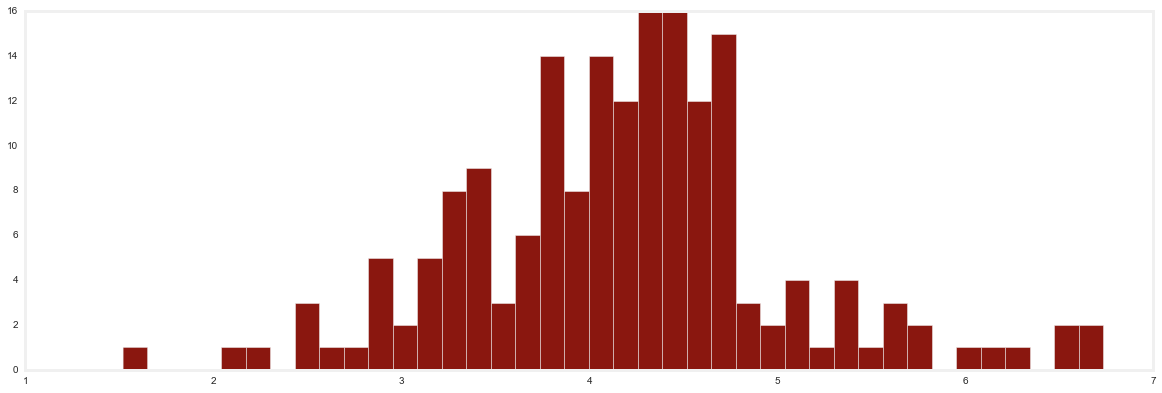

### Outer Feet Shim Changes

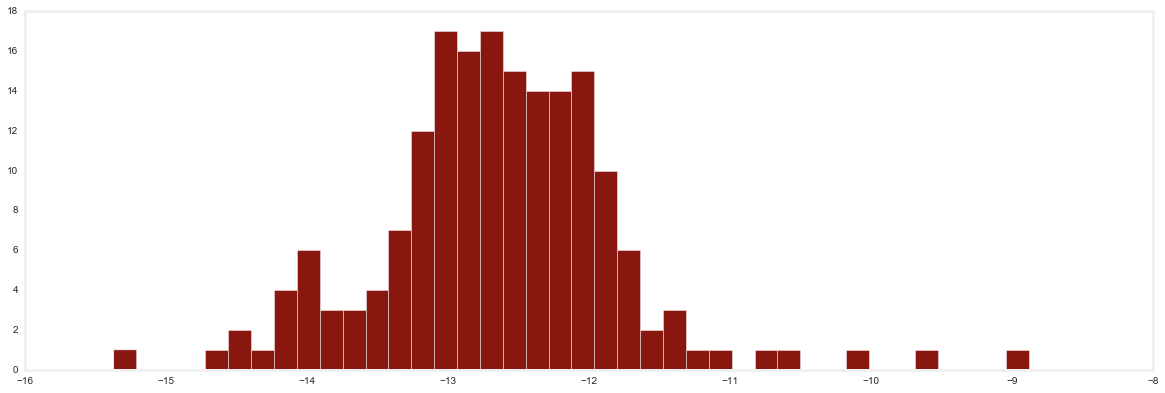

### Perfect Pole Adjustment Results

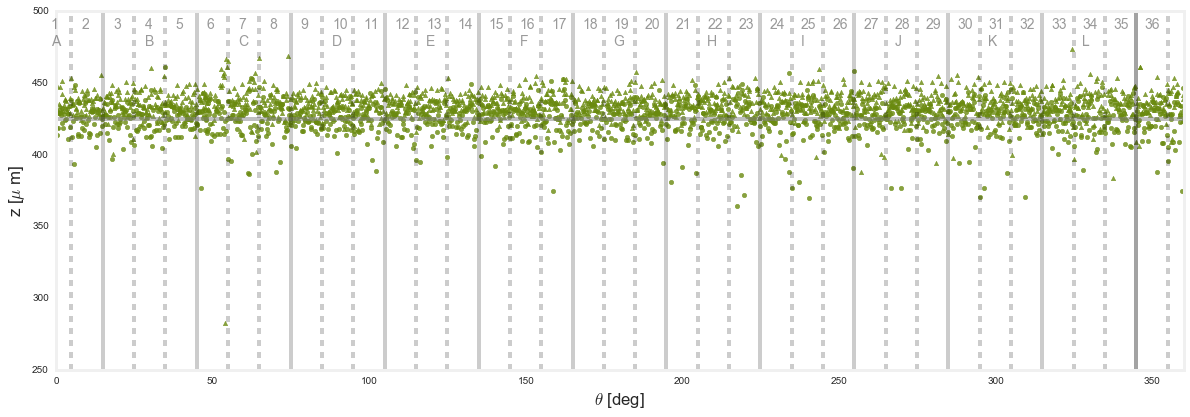

### Resulting Dipole Field

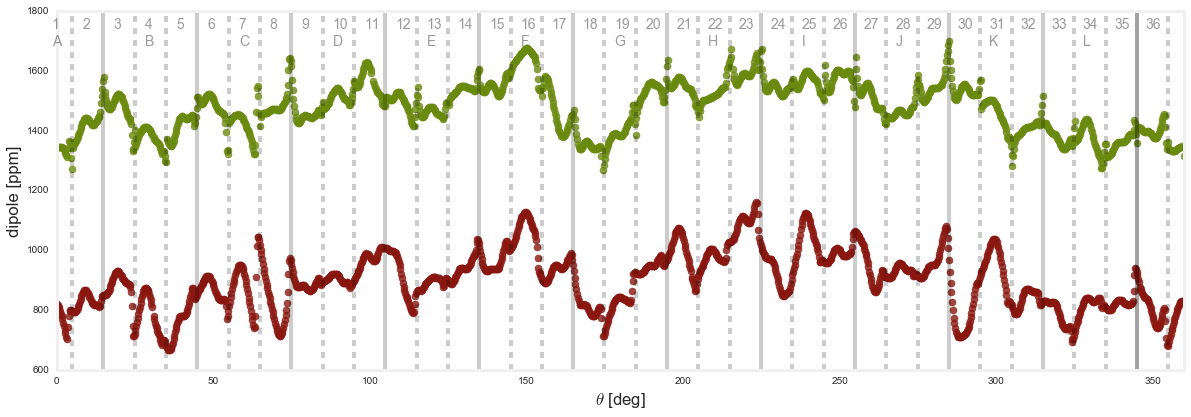

### Resulting Dipole Field

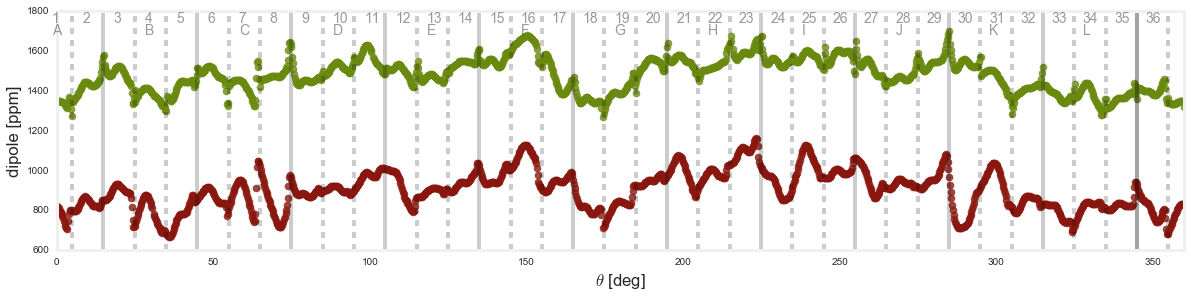

### Resulting Quadrupole Field

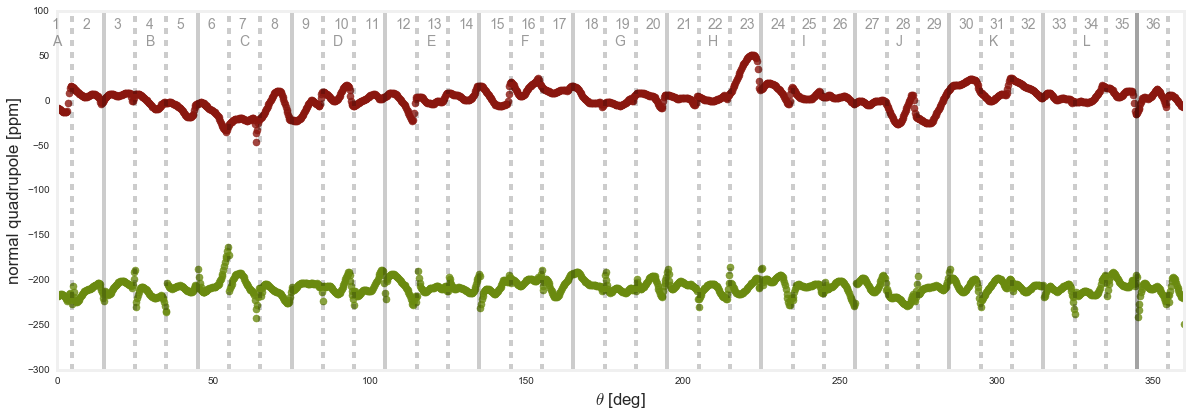

### Resulting Quadrupole Field

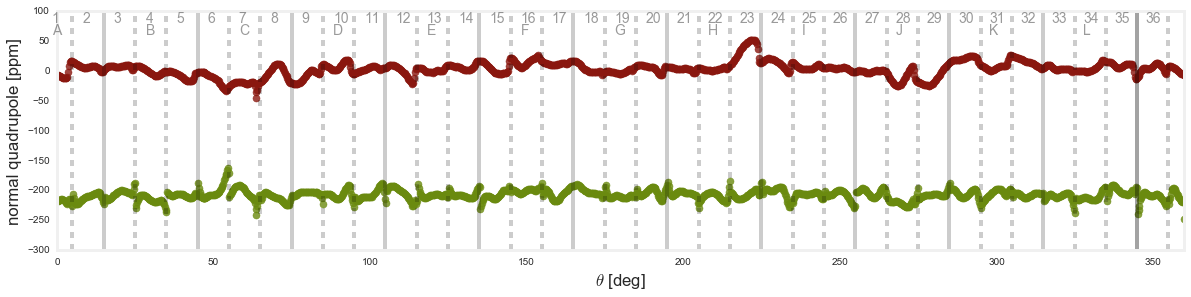

dipole ->  1477.74120634 84.7327086738
n_quad ->  -208.011906033 8.39019494288


### Pole 1 Movements

| Radius | A | B | C | D | E |
|-------|------|------|------|------|------|
| Inner | -4.70 | -4.28 | -4.64 | -3.84 | -6.54 |
| Outer | 14.07 | 12.18 | 12.23 | 12.51 | 13.18 |

### Pole 2 Movements

| Radius | A | B | C | D | E |
|-------|------|------|------|------|------|
| Inner | -4.93 | -4.84 | -4.38 | -4.01 | -3.65 |
| Outer | 12.91 | 13.15 | 12.85 | 12.86 | 14.14 |

### Pole 3 Movements

| Radius | A | B | C | D | E |
|-------|------|------|------|------|------|
| Inner | -3.47 | -4.50 | -3.92 | -4.37 | -2.65 |
| Outer | 13.42 | 13.00 | 12.62 | 12.62 | 12.60 |

### Pole 4 Movements

| Radius | A | B | C | D | E |
|-------|------|------|------|------|------|
| Inner | -5.13 | -4.47 | -4.38 | -3.76 | -5.04 |
| Outer | 14.02 | 12.45 | 12.57 | 13.00 | 13.85 |

### Pole 5 Movements

| Radius | A | B | C | D | E |
|-------|------|------|------|------|------|
| Inner | -2.91 | -3.35 | -2.94 | -3.29 | -3.53 |
| Outer | 13.02 | 12.94 | 12.63 | 12.18 | 12.95 |

### Pole 6 Movements

| Radius | A | B | C | D | E |
|-------|------|------|------|------|------|
| Inner | -2.51 | -3.85 | -3.28 | -2.23 | -1.52 |
| Outer | 11.99 | 12.59 | 12.30 | 11.37 | 8.88 |

### Pole 7 Movements

| Radius | A | B | C | D | E |
|-------|------|------|------|------|------|
| Inner | -2.95 | -3.07 | -3.34 | -3.46 | -4.60 |
| Outer | 11.79 | 10.60 | 10.80 | 11.95 | 10.07 |

### Pole 8 Movements

| Radius | A | B | C | D | E |
|-------|------|------|------|------|------|
| Inner | -4.67 | -3.67 | -3.64 | -3.48 | -2.55 |
| Outer | 11.12 | 12.45 | 14.20 | 14.25 | 12.23 |

### Pole 9 Movements

| Radius | A | B | C | D | E |
|-------|------|------|------|------|------|
| Inner | -2.89 | -3.27 | -3.69 | -3.92 | -4.93 |
| Outer | 12.05 | 11.29 | 12.11 | 12.15 | 13.64 |

### Pole 10 Movements

| Radius | A | B | C | D | E |
|-------|------|------|------|------|------|
| Inner | -4.45 | -4.05 | -4.21 | -4.05 | -4.16 |
| Outer | 12.82 | 12.72 | 13.31 | 12.92 | 13.95 |

### Pole 11 Movements

| Radius | A | B | C | D | E |
|-------|------|------|------|------|------|
| Inner | -3.39 | -3.91 | -4.13 | -4.05 | -5.66 |
| Outer | 12.96 | 13.00 | 13.30 | 11.98 | 12.57 |

### Pole 12 Movements

| Radius | A | B | C | D | E |
|-------|------|------|------|------|------|
| Inner | -4.56 | -4.30 | -3.71 | -3.28 | -4.68 |
| Outer | 11.95 | 11.80 | 12.42 | 12.58 | 13.96 |

### Pole 13 Movements

| Radius | A | B | C | D | E |
|-------|------|------|------|------|------|
| Inner | -2.48 | -4.31 | -4.05 | -4.31 | -4.63 |
| Outer | 12.64 | 12.65 | 12.32 | 12.26 | 13.28 |

### Pole 14 Movements

| Radius | A | B | C | D | E |
|-------|------|------|------|------|------|
| Inner | -3.86 | -4.14 | -4.01 | -4.51 | -4.01 |
| Outer | 12.42 | 13.08 | 12.88 | 12.86 | 12.60 |

### Pole 15 Movements

| Radius | A | B | C | D | E |
|-------|------|------|------|------|------|
| Inner | -6.09 | -4.21 | -4.03 | -3.78 | -4.68 |
| Outer | 14.13 | 13.16 | 12.77 | 11.83 | 13.33 |

### Pole 16 Movements

| Radius | A | B | C | D | E |
|-------|------|------|------|------|------|
| Inner | -4.52 | -4.36 | -4.42 | -4.59 | -3.45 |
| Outer | 13.12 | 12.57 | 12.43 | 13.09 | 12.78 |

### Pole 17 Movements

| Radius | A | B | C | D | E |
|-------|------|------|------|------|------|
| Inner | -4.54 | -4.25 | -5.71 | -5.34 | -4.68 |
| Outer | 13.50 | 13.23 | 12.53 | 11.74 | 11.93 |

### Pole 18 Movements

| Radius | A | B | C | D | E |
|-------|------|------|------|------|------|
| Inner | -4.41 | -4.29 | -3.99 | -4.14 | -3.93 |
| Outer | 12.27 | 11.92 | 12.16 | 12.08 | 12.43 |

### Pole 19 Movements

| Radius | A | B | C | D | E |
|-------|------|------|------|------|------|
| Inner | -3.14 | -4.16 | -4.29 | -4.12 | -5.63 |
| Outer | 11.70 | 12.47 | 12.14 | 12.81 | 12.08 |

### Pole 20 Movements

| Radius | A | B | C | D | E |
|-------|------|------|------|------|------|
| Inner | -4.45 | -4.24 | -3.52 | -4.19 | -2.90 |
| Outer | 12.06 | 12.89 | 12.43 | 12.40 | 12.58 |

### Pole 21 Movements

| Radius | A | B | C | D | E |
|-------|------|------|------|------|------|
| Inner | -3.38 | -4.63 | -4.42 | -3.79 | -5.59 |
| Outer | 11.98 | 12.04 | 12.02 | 12.59 | 13.51 |

### Pole 22 Movements

| Radius | A | B | C | D | E |
|-------|------|------|------|------|------|
| Inner | -5.16 | -4.44 | -4.39 | -4.68 | -3.39 |
| Outer | 12.82 | 12.03 | 11.97 | 13.07 | 12.16 |

### Pole 23 Movements

| Radius | A | B | C | D | E |
|-------|------|------|------|------|------|
| Inner | -3.75 | -6.32 | -6.74 | -6.61 | -3.03 |
| Outer | 13.25 | 13.25 | 13.84 | 13.68 | 12.64 |

### Pole 24 Movements

| Radius | A | B | C | D | E |
|-------|------|------|------|------|------|
| Inner | -4.41 | -4.70 | -3.83 | -3.41 | -4.74 |
| Outer | 13.44 | 12.99 | 13.01 | 13.19 | 14.21 |

### Pole 25 Movements

| Radius | A | B | C | D | E |
|-------|------|------|------|------|------|
| Inner | -4.63 | -4.74 | -4.79 | -4.45 | -4.75 |
| Outer | 14.00 | 11.93 | 11.87 | 12.44 | 12.62 |

### Pole 26 Movements

| Radius | A | B | C | D | E |
|-------|------|------|------|------|------|
| Inner | -3.25 | -4.23 | -3.77 | -4.07 | -6.49 |
| Outer | 13.03 | 12.61 | 12.51 | 13.03 | 11.78 |

### Pole 27 Movements

| Radius | A | B | C | D | E |
|-------|------|------|------|------|------|
| Inner | -3.80 | -3.98 | -3.69 | -3.93 | -4.70 |
| Outer | 12.21 | 11.60 | 12.91 | 12.46 | 12.12 |

### Pole 28 Movements

| Radius | A | B | C | D | E |
|-------|------|------|------|------|------|
| Inner | -4.29 | -3.97 | -4.44 | -5.25 | -2.07 |
| Outer | 12.12 | 11.56 | 11.92 | 12.99 | 11.85 |

### Pole 29 Movements

| Radius | A | B | C | D | E |
|-------|------|------|------|------|------|
| Inner | -3.13 | -3.11 | -3.11 | -4.39 | -2.74 |
| Outer | 12.61 | 11.44 | 11.73 | 12.17 | 13.20 |

### Pole 30 Movements

| Radius | A | B | C | D | E |
|-------|------|------|------|------|------|
| Inner | -3.46 | -3.21 | -3.29 | -3.83 | -4.75 |
| Outer | 13.69 | 14.70 | 15.37 | 14.04 | 14.44 |

### Pole 31 Movements

| Radius | A | B | C | D | E |
|-------|------|------|------|------|------|
| Inner | -5.30 | -4.70 | -4.74 | -4.72 | -5.37 |
| Outer | 13.26 | 12.02 | 11.37 | 12.27 | 12.72 |

### Pole 32 Movements

| Radius | A | B | C | D | E |
|-------|------|------|------|------|------|
| Inner | -6.00 | -4.91 | -5.12 | -4.46 | -3.31 |
| Outer | 12.91 | 13.30 | 12.99 | 12.66 | 13.36 |

### Pole 33 Movements

| Radius | A | B | C | D | E |
|-------|------|------|------|------|------|
| Inner | -4.65 | -4.44 | -4.32 | -3.84 | -4.28 |
| Outer | 13.26 | 12.70 | 12.68 | 12.66 | 14.49 |

### Pole 34 Movements

| Radius | A | B | C | D | E |
|-------|------|------|------|------|------|
| Inner | -3.83 | -4.10 | -4.34 | -5.31 | -4.29 |
| Outer | 12.97 | 12.81 | 12.77 | 12.39 | 12.40 |

### Pole 35 Movements

| Radius | A | B | C | D | E |
|-------|------|------|------|------|------|
| Inner | -5.77 | -4.17 | -4.55 | -4.56 | -3.79 |
| Outer | 13.26 | 11.83 | 12.27 | 12.82 | 9.61 |

### Pole 36 Movements

| Radius | A | B | C | D | E |
|-------|------|------|------|------|------|
| Inner | -5.54 | -4.25 | -4.27 | -4.08 | -4.03 |
| Outer | 12.72 | 12.33 | 13.07 | 13.53 | 13.77 |

In [12]:
# Set the weights
w2 = 0.5 * (pole_width_m - ctec_width_m) / pole_width_m
w1 = 1.0 - w2

display(Markdown('### Top Pole - Inner Height Goal'))
plt.scatter(ctec_phi, ctec_inner_up + ctec_inner_lo, color=colors[2], alpha=0.75)

plt.axhline(top_z0 + 0.0, color='gray', alpha=0.5)
for i in xrange(-5, 5):
    plt.axhline(top_z0 + i * 25, color='gray', linestyle='--', alpha=0.25)

finish_plot()

display(Markdown('### Top Pole - Outer Height Goal'))
plt.scatter(ctec_phi, ctec_outer_up + ctec_outer_lo, color=colors[2], alpha=0.75)

plt.axhline(top_z0 + 0.0, color='gray', alpha=0.5)
for i in xrange(-5, 5):
    plt.axhline(top_z0 + i * 25, color='gray', linestyle='--', alpha=0.25)

finish_plot()

# Convenience variables
moves = np.zeros([36, 10])
mean_pole_z = np.zeros(36)

output = ['| Radius | A | B | C | D | E |']
output.append('|-------|------|------|------|------|------|')
output.append('| Inner | %.2f | %.2f | %.2f | %.2f | %.2f |')
output.append('| Outer | %.2f | %.2f | %.2f | %.2f | %.2f |')

for i in xrange(36):

    if freeze_top_pole[i]:
        moves[i, :] = 0.0
        continue
        
    # Calculate the height displacement
    idx = np.where((ctec_phi - (10.0 * i - 5.0)) % 360 < 10.0)
    t_zi = (ctec_inner_lo + ctec_inner_up)[idx]
    t_zo = (ctec_outer_lo + ctec_outer_up)[idx]    
    t_phi = ctec_phi[idx]

    pi = fit_params_inner[i, :]
    po = fit_params_outer[i, :]
    for j in xrange(5):
        a = -pole_feet_phi_from_center + pole_feet_phi_spacing * j
        inner_z = pole5(a, pi[0], pi[1], pi[2], pi[3], pi[4], pi[5], pi[6], pi[7])
        outer_z = pole5(a, po[0], po[1], po[2], po[3], po[4], po[5], po[6], po[7])
        moves[i, j] = top_z0 - w1 * inner_z - w2 * outer_z
        moves[i, j + 5] = top_z0 - w2 * inner_z - w1 * (outer_z + ctec_width_m * top_rad0)

#         if i > 0 and j == 4:
#             print i
#             print moves[i, 0] - moves[i - 1, 4]
#             print moves[i, 5] - moves[i - 1, 9]
            
        dm = moves[i, j] - moves[i , j + 5]
        moves[i, j] += dm * pole_width_m / ctec_width_m
        moves[i, j + 5] -= dm * pole_width_m / ctec_width_m

# Copy moves so that it doesn't change while we are correcting it.
t_moves = np.array(moves)

display(Markdown('### Top Pole Adjustment Plan'))
plt.scatter(ctec_phi, ctec_inner_up + ctec_inner_lo, color='#bdbdbd', alpha=1.0)
plt.scatter(ctec_phi, ctec_outer_up + ctec_outer_lo, marker='^', color='#bdbdbd', alpha=1.0)

for i in xrange(36):
    t_phi = np.linspace(10.0 * i - pole_feet_phi_from_center, 10.0 * i + pole_feet_phi_from_center, 5)
    plt.scatter(t_phi, top_z0 - moves[i, :5], alpha=0.9, s=50.0, color=colors[i%10])
    plt.scatter(t_phi, top_z0 - moves[i, 5:], alpha=0.9, s=50.0, marker='^', color=colors[i%10])

for i in xrange(-4, 10):
    plt.axhline(top_z0 + i * 25, color='gray', linestyle='--', alpha=0.25)

plt.axhline(top_z0 + 0.0, color='gray', alpha=0.5)
finish_plot()

plt.scatter(ctec_phi, b_n_quad, c=colors[0])
plt.scatter(pole_feet_phi, 0.5 * (moves[:, :5] - moves[:, 5:]).flatten(), s=100.0, c=colors[2])
finish_plot(r'$\delta$z [$\mu m$] / normal quadrupole [ppm]')

# display(Markdown('### Pole Steps'))

# c = 53.0 / 29.845
# plt.plot(np.linspace(5, 355, 36), c * dz, color=colors[0], alpha=0.2)
# plt.plot(np.linspace(5, 355, 36), c * dz_outer, color=colors[2], alpha=0.2)

# plan_dz_inner = np.empty(36)
# plan_dz_outer = np.empty(36)

# plan_dz_inner[:35] = (moves[1:, 0] - moves[:-1, 4])
# plan_dz_inner[-1] = (moves[0, 0] - moves[-1, 4])
# plan_dz_outer[:35] = (moves[1:, 5] - moves[:-1, 9])
# plan_dz_outer[-1] = (moves[0, 5] - moves[-1, 9])

# plt.plot(np.linspace(5, 355, 36), -plan_dz_inner, color=colors[0], alpha=0.8)
# plt.plot(np.linspace(5, 355, 36), -plan_dz_outer, color=colors[2], alpha=0.8)
# plt.axhline(50, color='gray', alpha=0.5)
# plt.axhline(25, color='gray', alpha=0.5)
# plt.axhline(0, color='gray', alpha=0.5)
# plt.axhline(-25, color='gray', alpha=0.5)
# plt.axhline(-50, color='gray', alpha=0.5)
# finish_plot()

display(Markdown('### Inner Feet Shim Changes'))
plt.hist(moves[:, :5].flatten() / 25.4, bins=40, color=colors[0])
plt.show()

display(Markdown('### Outer Feet Shim Changes'))
plt.hist(moves[:, 5:].flatten() / 25.4, bins=40, color=colors[0])
plt.show()

display(Markdown('### Perfect Pole Adjustment Results'))

final_z_inner = np.array(ctec_inner_up + ctec_inner_lo)
final_z_outer = np.array(ctec_outer_up + ctec_outer_lo)

db_dipole = np.empty(ctec_inner_up.shape)
db_n_quad = np.empty(ctec_inner_up.shape)

for i in xrange(ctec_phi.shape[0]):
    n = int(((ctec_phi[i] + 5.0) % 360) / 10.0)
    pi = fit_params_inner[n, :]
    po = fit_params_outer[n, :]
    a = (ctec_phi[i] + 5.0) % 10.0 - 5.0

    dz_inner = pole5(a, pi[0], pi[1], pi[2], pi[3], pi[4], pi[5], pi[6], pi[7]) - top_z0
    dz_outer = pole5(a, po[0], po[1], po[2], po[3], po[4], po[5], po[6], po[7]) + top_rad0 * ctec_width_m - top_z0
    
    final_z_inner[i] -= dz_inner
    final_z_outer[i] -= dz_outer

    db_dipole[i] = ppm_dipole_per_um * 0.5 * (dz_inner + dz_outer)
    db_n_quad[i] = ppm_n_quad_per_urad * (dz_inner - dz_outer) / ctec_width_m

plt.scatter(ctec_phi, final_z_inner, color=colors[2], alpha=0.8)
plt.scatter(ctec_phi, final_z_outer, marker='^', color=colors[2], alpha=0.8)
plt.axhline(top_z0 + 0.0, color='gray', alpha=0.5)
finish_plot()

t_phi = np.hstack((ctec_phi[-50:] - 360.0, ctec_phi, ctec_phi[:50] + 360.0))
t_dipole = np.hstack((db_dipole[-50:] - 360.0, db_dipole, db_dipole[:50] + 360.0))
t_n_quad = np.hstack((db_n_quad[-50:] - 360.0, db_n_quad, db_n_quad[:50] + 360.0))

display(Markdown('### Resulting Dipole Field'))
dipole = b_dipole - interp1d(t_phi, t_dipole)(b_phi)
plt.scatter(b_phi, b_dipole, color=colors[0], s=50.0, alpha=0.8)
plt.scatter(b_phi, dipole, color=colors[2], s=50.0, alpha=0.8)
finish_plot('dipole [ppm]')

mpl.rcParams['figure.figsize'] = (18, 4)
display(Markdown('### Resulting Dipole Field'))
dipole = b_dipole - interp1d(t_phi, t_dipole)(b_phi)
plt.scatter(b_phi, b_dipole, color=colors[0], s=50.0, alpha=0.8)
plt.scatter(b_phi, dipole, color=colors[2], s=50.0, alpha=0.8)
finish_plot('dipole [ppm]')

mpl.rcParams['figure.figsize'] = (18, 6)
display(Markdown('### Resulting Quadrupole Field'))
n_quad = b_n_quad - interp1d(t_phi, t_n_quad)(b_phi)
plt.scatter(b_phi, b_n_quad, color=colors[0], s=50.0, alpha=0.8)
plt.scatter(b_phi, n_quad, color=colors[2], s=50.0, alpha=0.8)
finish_plot('normal quadrupole [ppm]')

mpl.rcParams['figure.figsize'] = (18, 4)
display(Markdown('### Resulting Quadrupole Field'))
n_quad = b_n_quad - interp1d(t_phi, t_n_quad)(b_phi)
plt.scatter(b_phi, b_n_quad, color=colors[0], s=50.0, alpha=0.8)
plt.scatter(b_phi, n_quad, color=colors[2], s=50.0, alpha=0.8)
finish_plot('normal quadrupole [ppm]')

mpl.rcParams['figure.figsize'] = (18, 6)
print "dipole -> ", dipole.mean(), dipole.std()
print "n_quad -> ", n_quad.mean(), n_quad.std()
np.savetxt('b_phi.txt', b_phi)
np.savetxt('dipole.txt', dipole)
np.savetxt('n_quad.txt', n_quad)

# Print the values.
for i in xrange(36):
    display(Markdown('### Pole %i Movements' % (i + 1)))
    display(Markdown('\n'.join(output) % tuple(-moves[i, :] / 25.4)))
    
np.savetxt('data-out/global-top-pole-adjustments.csv', moves)